In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-image-classification/Cars Dataset/test/Hyundai Creta/208.jpg
/kaggle/input/car-image-classification/Cars Dataset/test/Hyundai Creta/45.jpg
/kaggle/input/car-image-classification/Cars Dataset/test/Hyundai Creta/58.jpg
/kaggle/input/car-image-classification/Cars Dataset/test/Hyundai Creta/342.jpg
/kaggle/input/car-image-classification/Cars Dataset/test/Hyundai Creta/151.jpg
/kaggle/input/car-image-classification/Cars Dataset/test/Hyundai Creta/283.jpg
/kaggle/input/car-image-classification/Cars Dataset/test/Hyundai Creta/118.jpg
/kaggle/input/car-image-classification/Cars Dataset/test/Hyundai Creta/113.jpg
/kaggle/input/car-image-classification/Cars Dataset/test/Hyundai Creta/328.jpg
/kaggle/input/car-image-classification/Cars Dataset/test/Hyundai Creta/42.jpg
/kaggle/input/car-image-classification/Cars Dataset/test/Hyundai Creta/291.jpg
/kaggle/input/car-image-classification/Cars Dataset/test/Hyundai Creta/178.jpg
/kaggle/input/car-image-classification/Cars Dataset/tes

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201, EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image

In [3]:
train_dir = "/kaggle/input/car-image-classification/Cars Dataset/train"
test_dir = "/kaggle/input/car-image-classification/Cars Dataset/test"


**Check corrupt images**

In [4]:
def check_and_remove_corrupt_images(directory):
    print(f"Checking folder: {directory}")
    count = 0
    for class_folder in os.listdir(directory):
        folder_path = os.path.join(directory, class_folder)
        if not os.path.isdir(folder_path):
            continue

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # verifies if image is broken
            except (IOError, SyntaxError):
                print(f"Corrupted image removed: {img_path}")
                os.remove(img_path)
                count += 1
    print(f"Total corrupted images removed from '{directory}': {count}\n")

# Run function for both datasets
check_and_remove_corrupt_images(train_dir)
check_and_remove_corrupt_images(test_dir)

Checking folder: /kaggle/input/car-image-classification/Cars Dataset/train
Total corrupted images removed from '/kaggle/input/car-image-classification/Cars Dataset/train': 0

Checking folder: /kaggle/input/car-image-classification/Cars Dataset/test
Total corrupted images removed from '/kaggle/input/car-image-classification/Cars Dataset/test': 0



**Class destribution**

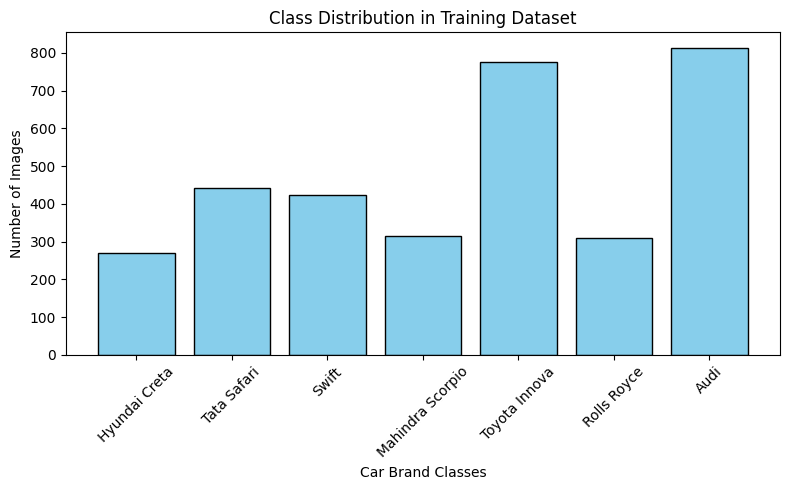

In [5]:

# Count images in each class folder
class_names = []
image_counts = []

for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_names.append(class_folder)
        image_counts.append(count)

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(class_names, image_counts, color='skyblue', edgecolor='black')
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Car Brand Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Visualization**

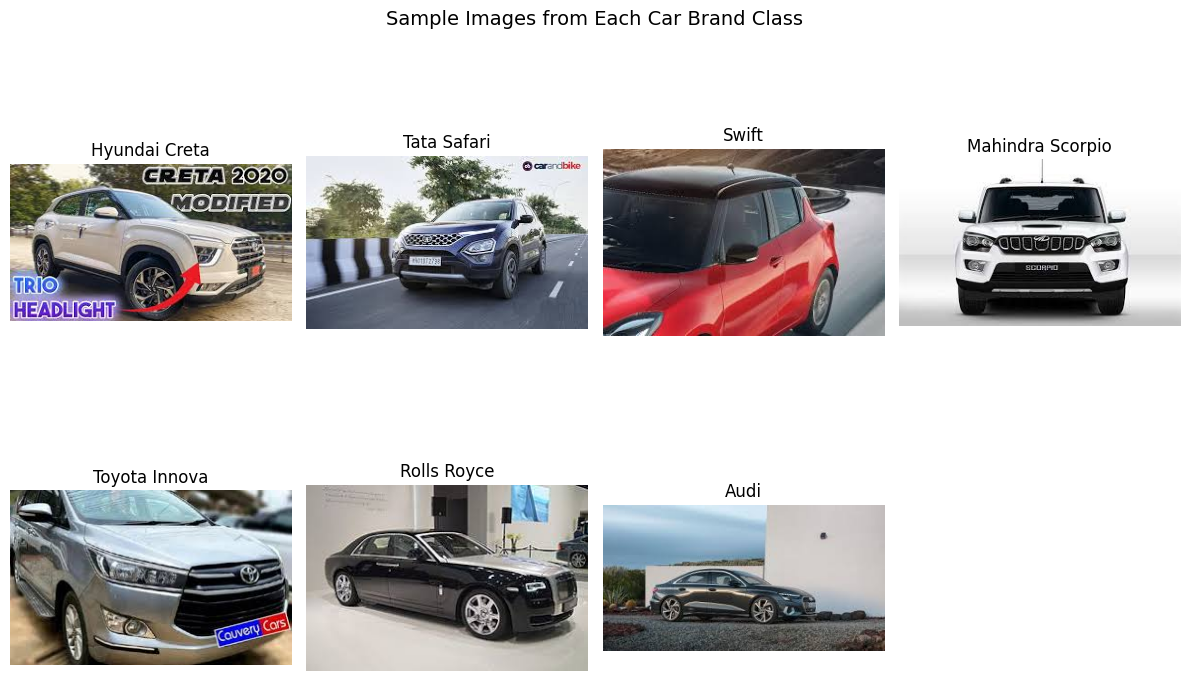

In [6]:
import matplotlib.image as mpimg
import random

plt.figure(figsize=(12, 8))

for i, cls in enumerate(class_names[:7]):  # Show one image per class (adjust as needed)
    class_path = os.path.join(train_dir, cls)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    
    img = mpimg.imread(img_path)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.suptitle("Sample Images from Each Car Brand Class", fontsize=14)
plt.tight_layout()
plt.show()


**Preprocessing: Resize, Grayscale, Normalize**

In [7]:
import os
import cv2
import numpy as np


IMG_SIZE = (224, 224)

X = []  # images
y = []  # labels
labels = os.listdir(train_dir)

for label in labels:
    folder_path = os.path.join(train_dir, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        # Convert to grayscale (optional)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize
        img = cv2.resize(img, IMG_SIZE)

        # Normalize (scale pixel values between 0 and 1)
        img = img / 255.0

        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape)


Dataset shape: (3352, 224, 224, 3)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Rescale (Normalize pixel values between 0 and 1)
# Convert to grayscale only if your dataset has color-irrelevant images
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalization
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/car-image-classification/Cars Dataset/train',
    target_size=IMG_SIZE,   # Resize all images to 224x224
    color_mode='rgb',       # use 'grayscale' if dataset should be gray
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/car-image-classification/Cars Dataset/test',
    target_size=IMG_SIZE,
    color_mode='rgb',       # or 'grayscale'
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3352 images belonging to 7 classes.
Found 813 images belonging to 7 classes.


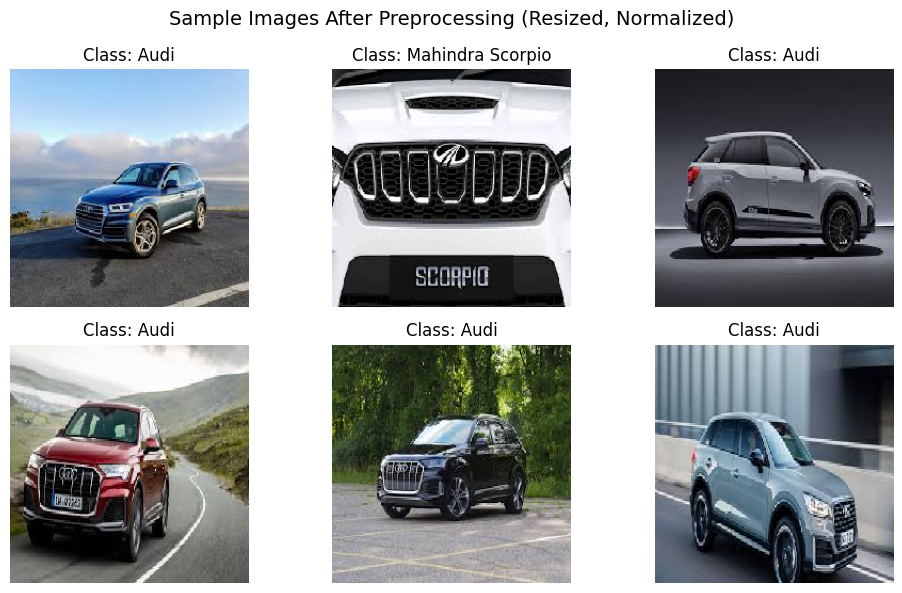

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of preprocessed images from the generator
images, labels = next(train_generator)

# Denormalize for visualization (from 0–1 back to 0–255)
images = images * 255

# Display a few preprocessed images
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = images[i].astype('uint8')   # Convert float to uint8 for display
    plt.imshow(img)
    plt.title(f"Class: {list(train_generator.class_indices.keys())[np.argmax(labels[i])]}")
    plt.axis('off')

plt.suptitle("Sample Images After Preprocessing (Resized, Normalized)", fontsize=14)
plt.tight_layout()
plt.show()


**Data Augmentation (Rotation, Flipping, Shearing)**

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation setup
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,           # Normalize
    rotation_range=30,        # Random rotation (in degrees)
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest'       # Fill empty pixels
)

# Load augmented data from the directory
train_dir = "/kaggle/input/car-image-classification/Cars Dataset/train"

train_augmented = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 3352 images belonging to 7 classes.


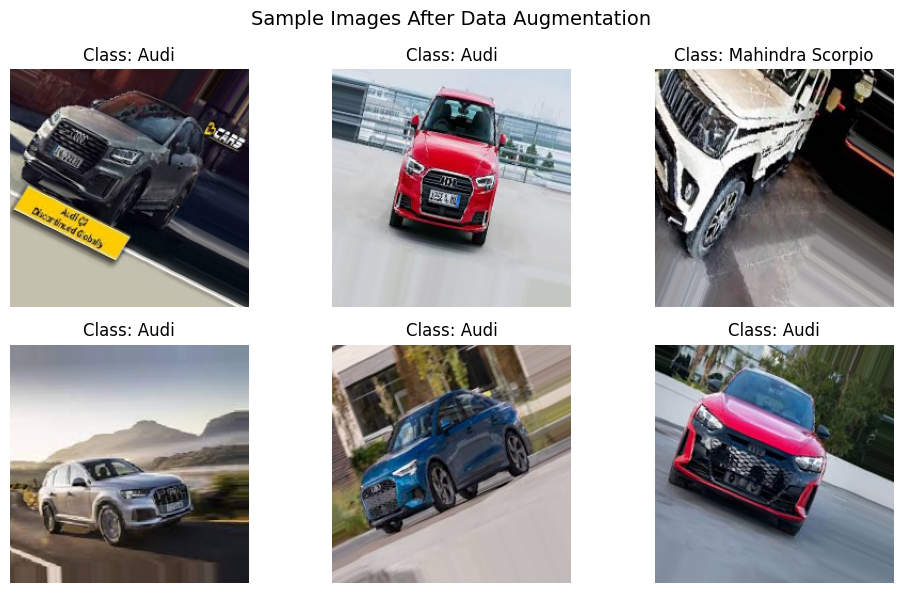

In [11]:
# Get a batch of augmented images
images, labels = next(train_augmented)

# Denormalize for visualization
images = images * 255

# Show multiple augmented versions
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = images[i].astype('uint8')
    plt.imshow(img)
    plt.title(f"Class: {list(train_augmented.class_indices.keys())[np.argmax(labels[i])]}")
    plt.axis('off')

plt.suptitle("Sample Images After Data Augmentation", fontsize=14)
plt.tight_layout()
plt.show()


**Train & Test Split**

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/car-image-classification/Cars Dataset/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/car-image-classification/Cars Dataset/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3352 images belonging to 7 classes.
Found 813 images belonging to 7 classes.


# DenseNet201

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam


In [14]:

IMG_SIZE = (224, 224)
num_classes = 7  # Number of car brands
dropout_rate = 0.4

# ------------------------------
# Load Pretrained DenseNet201
# ------------------------------
from tensorflow.keras.applications import DenseNet201

base_model = DenseNet201(
    weights='/kaggle/input/densenet201/densenet201_weights_tf_dim_ordering_tf_kernels_notop (1).h5',
    include_top=False,
    input_shape=(224,224,3)
)
base_model.trainable = False   # Freeze base layers for initial training

# ------------------------------
# Build the Model
# ------------------------------
model_densenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),   # Flatten feature maps
    layers.Dense(256, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

# ------------------------------
# Compile the Model
# ------------------------------
model_densenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ------------------------------
# Model Summary
# ------------------------------
model_densenet.summary()


2025-10-07 12:53:44.414230: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,815,559 (71.78 MB)

 Trainable params: 493,575 (1.88 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Stop training if validation loss doesn't improve
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Optional: save best model
checkpoint = ModelCheckpoint("vehicle_densenet201.h5", monitor='val_accuracy', save_best_only=True)


In [16]:
history = model_densenet.fit(
    train_generator,
    validation_data=test_generator,   # or val_generator if you have split
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 663s 6s/step - accuracy: 0.3313 - loss: 1.8259 - val_accuracy: 0.6507 - val_loss: 1.1374
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 615s 6s/step - accuracy: 0.6027 - loss: 1.1603 - val_accuracy: 0.7823 - val_loss: 0.8250
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 604s 6s/step - accuracy: 0.7131 - loss: 0.8688 - val_accuracy: 0.8253 - val_loss: 0.6524
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 606s 6s/step - accuracy: 0.7795 - loss: 0.7241 - val_accuracy: 0.8462 - val_loss: 0.5527
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 614s 6s/step - accuracy: 0.8051 - loss: 0.6214 - val_accuracy: 0.8672 - val_loss: 0.4881
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 604s 6s/step - accuracy: 0.8407 - loss: 0.5384 - val_accuracy: 0.8954 - val_loss: 0.4371
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 611s 6s/step - accuracy: 0.8481 - loss: 0.4879 - val_accuracy: 0.8954 - val_loss: 0.3945
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 603s 6s/step - accuracy: 0.8671 - loss: 0.4546 - val_accu

In [18]:
# Evaluate model on test set
test_loss, test_accuracy = model_densenet.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step - accuracy: 0.8987 - loss: 0.3607
Test Accuracy: 91.14%
Test Loss: 0.3272


**accuracy and loss curve**

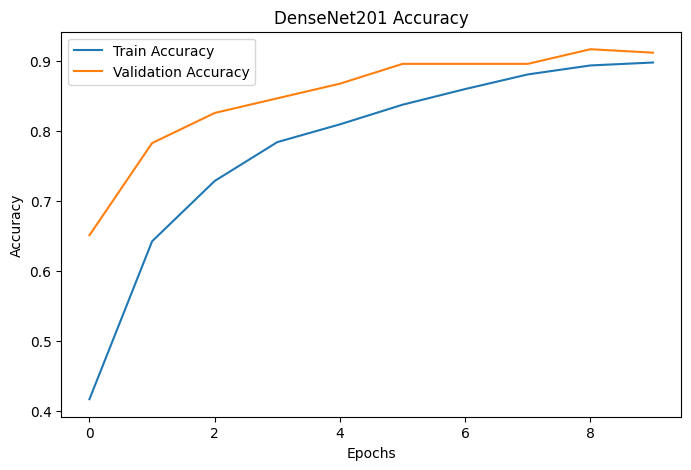

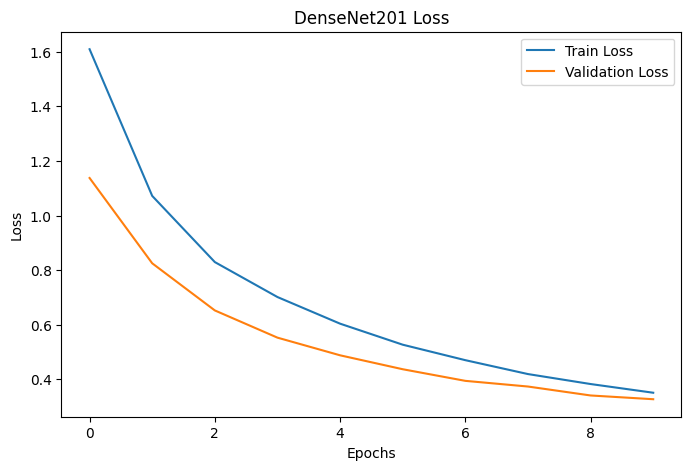

In [17]:
# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("DenseNet201 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("DenseNet201 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


**Confusion Matrix**

26/26 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step
Classification Report:

                  precision    recall  f1-score   support

            Audi       0.94      0.90      0.92       199
   Hyundai Creta       0.85      0.75      0.79        67
Mahindra Scorpio       0.92      0.95      0.93        75
     Rolls Royce       0.88      0.86      0.87        74
           Swift       0.97      0.87      0.92       102
     Tata Safari       0.84      0.96      0.90       106
   Toyota Innova       0.93      0.97      0.95       190

        accuracy                           0.91       813
       macro avg       0.90      0.90      0.90       813
    weighted avg       0.91      0.91      0.91       813



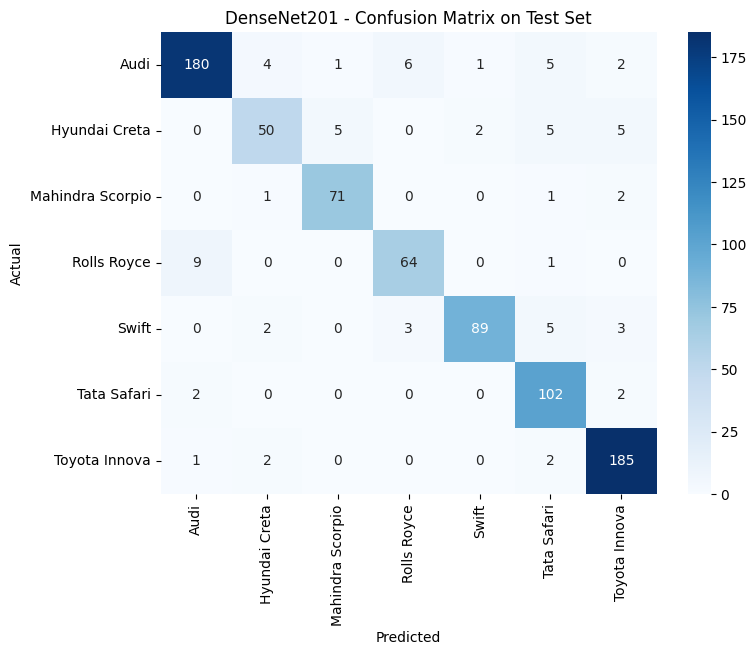

In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes
y_pred = np.argmax(model_densenet.predict(test_generator), axis=1)
y_true = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet201 - Confusion Matrix on Test Set')
plt.show()


**ROC Curve**

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
# Predict probabilities for test set
y_score = model_densenet.predict(test_generator)  # shape: (num_samples, num_classes)

# True labels
y_true = test_generator.classes

# Binarize the true labels for multi-class ROC
num_classes = len(test_generator.class_indices)
y_true_bin = label_binarize(y_true, classes=range(num_classes))

class_labels = list(test_generator.class_indices.keys())


26/26 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step


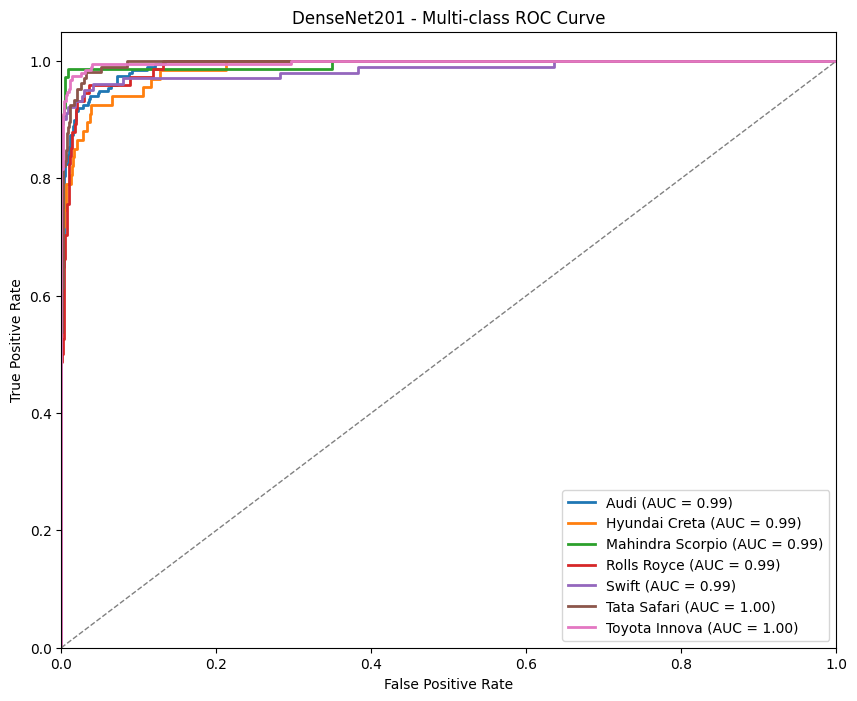

In [21]:
plt.figure(figsize=(10,8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DenseNet201 - Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()


# MobileNetV2

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# ------------------------------
# Parameters
# ------------------------------
IMG_SIZE = (224, 224)
num_classes = 7  # Number of car brands
dropout_rate = 0.4

# ------------------------------
# Load Pretrained MobileNetV2
# ------------------------------
base_model = MobileNetV2(
    weights='/kaggle/input/mobilenet/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top (2).h5',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False   # Freeze base layers initially

# ------------------------------
# Build the Model
# ------------------------------
model_mobilenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(num_classes, activation='softmax')
])

# ------------------------------
# Compile the Model
# ------------------------------
model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ------------------------------
# Model Summary
# ------------------------------
model_mobilenet.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
EPOCHS = 10
BATCH_SIZE = 32

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Save the best model
checkpoint = ModelCheckpoint('mobilenetv2_best.h5', monitor='val_accuracy', save_best_only=True)


In [34]:
history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=test_generator,   # Or val_generator if you split train data
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.3544 - loss: 1.7695 - val_accuracy: 0.6740 - val_loss: 1.0269
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 105s 999ms/step - accuracy: 0.6438 - loss: 1.0469 - val_accuracy: 0.7601 - val_loss: 0.7763
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 104s 989ms/step - accuracy: 0.7340 - loss: 0.8358 - val_accuracy: 0.8007 - val_loss: 0.6454
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.7949 - loss: 0.6791 - val_accuracy: 0.8229 - val_loss: 0.5657
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8245 - loss: 0.5846 - val_accuracy: 0.8303 - val_loss: 0.5159
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 103s 984ms/step - accuracy: 0.8265 - loss: 0.5278 - val_accuracy: 0.8401 - val_loss: 0.4715
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 103s 977ms/step - accuracy: 0.8605 - loss: 0.4457 - val_accuracy: 0.8647 - val_loss: 0.4439
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8679 - loss: 0.436

In [35]:
# Evaluate model on test set
test_loss, test_accuracy = model_mobilenet.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 760ms/step - accuracy: 0.8549 - loss: 0.3939
Test Accuracy: 86.96%
Test Loss: 0.3822


**accuracy and loss curve**

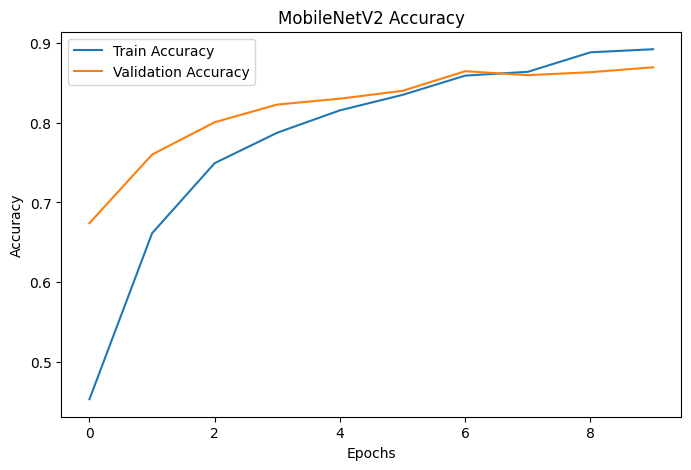

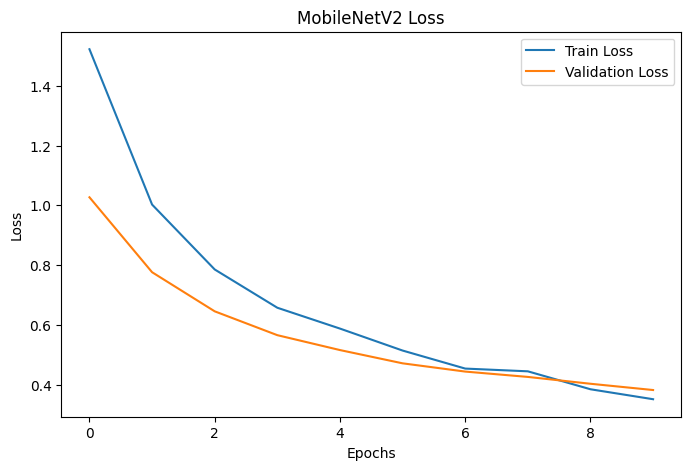

In [36]:
# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title("MobileNetV2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title("MobileNetV2 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


**Confusion Matrix**

26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 882ms/step
Classification Report:

                  precision    recall  f1-score   support

            Audi       0.86      0.89      0.88       199
   Hyundai Creta       0.75      0.72      0.73        67
Mahindra Scorpio       0.89      0.88      0.89        75
     Rolls Royce       0.82      0.72      0.76        74
           Swift       0.91      0.84      0.87       102
     Tata Safari       0.89      0.90      0.89       106
   Toyota Innova       0.90      0.95      0.92       190

        accuracy                           0.87       813
       macro avg       0.86      0.84      0.85       813
    weighted avg       0.87      0.87      0.87       813



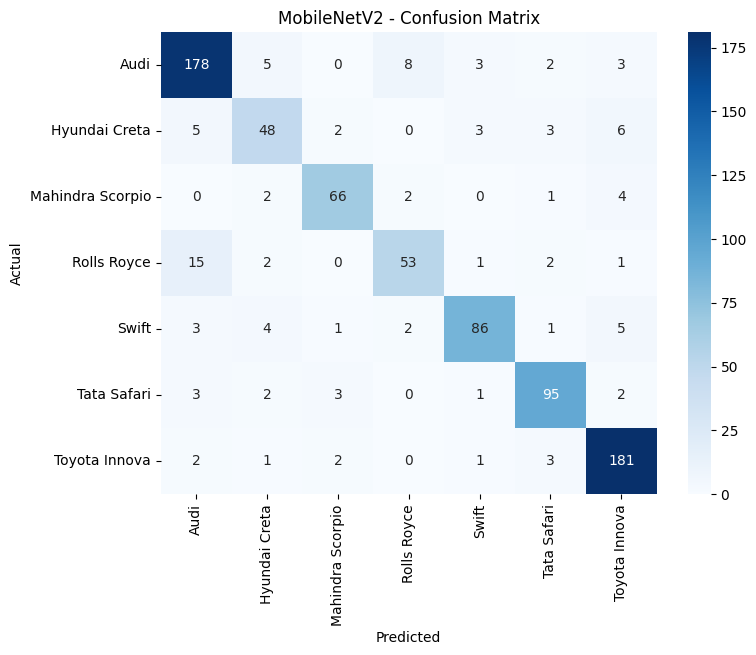

In [37]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_prob = model_mobilenet.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('MobileNetV2 - Confusion Matrix')
plt.show()


**ROC Curve**

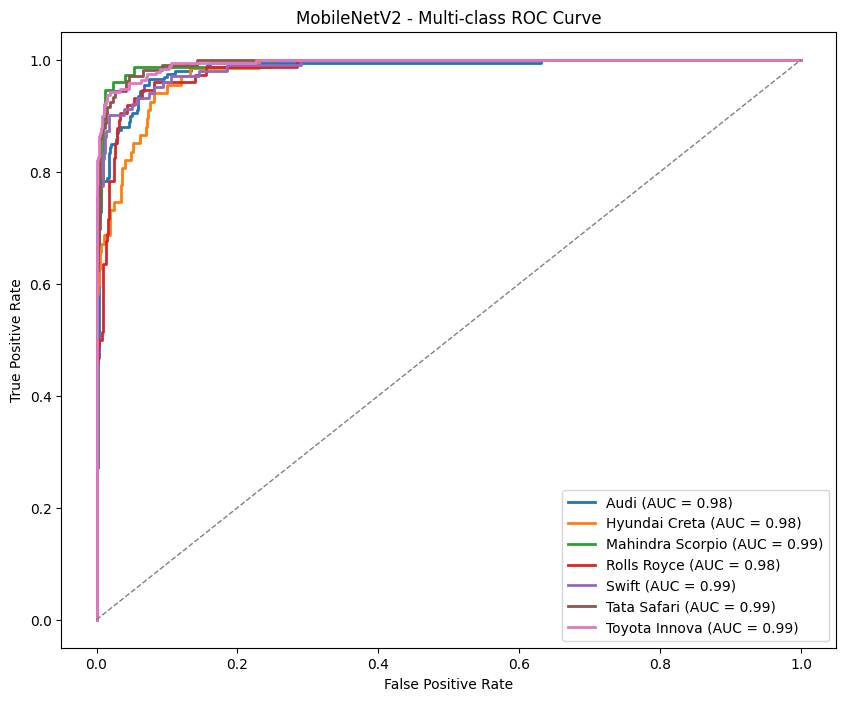

In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize true labels
y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))

plt.figure(figsize=(10,8))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MobileNetV2 - Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()
